In [1]:
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, Aug_Koopman_ModelQP, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
import csv
import pickle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

In [2]:
file_name_results = 'Air_Passenger_QPAug_Koopman'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")  

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/Air_Passenger_QPAug_Koopman/  already exists, overwriting results


Text(0, 0.5, 'y')

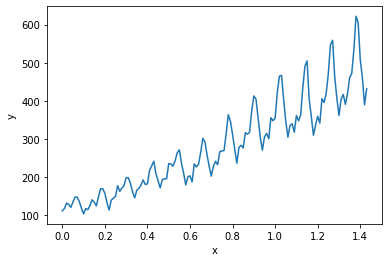

In [3]:
np.random.seed(42)
dim = 1
true_y = np.genfromtxt('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', delimiter=',')[1:,1]


csvfile = open('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', 'r')
reader = csv.reader(csvfile, delimiter='\t')
my_list = list(reader)
dates = []
dates_to_plot = []
for i in range(144):
    dates.append(my_list[1+i][0][:7].replace("-", "/"))
    dates_to_plot.append('')
formated_dates = [dt.datetime.strptime(d,'%Y/%m').date() for d in dates]
true_t = np.linspace(0, (true_y.shape[0]-1)/100, true_y.shape[0])
plt.plot(true_t,true_y)
plt.xlabel("x")
plt.ylabel("y")

In [4]:
dt   = true_t[1]-true_t[0]
S_train = true_y[:100].reshape(1,-1,1)
S_test  = true_y[100:].reshape(1,-1,1)
T_train = true_t[:100].reshape(1,-1,1)
T_test  = true_t[100:].reshape(1,-1,1)
Batch_size = S_train.shape[1]
X_train = S_train[0,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = int(X_train.shape[0]/Batch_size)
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
T_train = torch.from_numpy(T_train.reshape(nb_Batch,Batch_size,dim)).double()
batch_size_test = X_test.shape[1]
nb_batch_test   = int(X_test.shape[1]/batch_size_test)
X_test  = torch.from_numpy(X_test[:,:,:].reshape(nb_batch_test,batch_size_test,-1)).double()
T_test  = torch.from_numpy(T_test[:,:,:].reshape(nb_batch_test,batch_size_test,-1)).double()


In [5]:
dim_aug = 50
dim = 1
params = {}
params['description']='simple_QP_model_'+str(dim_aug+dim)
params['dim_input']=dim
params['dim_output']=dim_aug
params['dt_integration'] = dt
params['nb_Batch'] = nb_Batch
params['ntrain']=[7350,1]
params['dim_latent'] = dim_aug-dim
params['Imag_Eigen'] = True
params['Batch_size'] = Batch_size
params['transition_layers2'] = 0
params['transition_layers']  = 0
params['bi_linear_layers']   = 0
params['dim_hidden_linear']  = 0

In [6]:
params_learn = {}
params_learn['train_dir']    = '/home/saidouala/Documents/KoopmanReduction/Output_models/'
params_learn['train_repo']   = params['description']
params_learn['lr']           = .1
params_learn['len_seq_pred'] = 300
params_learn['Pretrained']   = False

In [7]:
periodic_kernel = Aug_Koopman_Model(params)
model = Aug_Koopman_ModelQP(params,periodic_kernel)
model_Multi_RINN = Multi_INT_net(params,model)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(model.parameters(),lr = params_learn['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = 0.9, patience=20, verbose=True, min_lr = 0.001)

In [8]:
# Learning loop
if params_learn['Pretrained']:
    model.load_state_dict(torch.load(output_file_folder + file_name_results + '.pt'))
else:
    lam = 0.01
    aug_inp_count = []
    for t in range(params['ntrain'][0]):
            for b in range(nb_Batch):
                    inp_conc = torch.cat((X_train[b,:,:],model.Periodic_kernel.y_aug[b,:,:]),dim = -1)
                    pred, grad, phi = model(inp_conc[:-1,:],T_train[0,1:,:],T_train[0,:-1,:])[:3]
                    preds, error1 = [pred], [criterion(pred[:,:], inp_conc[1:,:])]#, [criterion(pred[:-1,dim:], inp_conc[1:,dim:])]
    #                for i in range(1,50,20):
    #                    pred, grad, phi = model(inp_conc[:-1,:],T_train[0,1:,:]*i,T_train[0,:-1,:])[:3]
    #                    preds, error2 = [pred], criterion(pred[:-i,:][::i,:], inp_conc[:-1,:][i:,:][::i,:])#, [criterion(pred[::2,:][:-1,dim:], inp_conc[1:,dim:])]
    #                    error1.append(error2)
                    loss = torch.stack(error1).mean() #+ 1000*torch.stack(error_aug).mean()
                    loss = loss
    #                print(t,b,loss)
                    optimizer.zero_grad()
                    # Zero gradients, perform a backward pass, and update the weights.
                    loss.backward(retain_graph=True)
                    for param_group in optimizer.param_groups:
                        print(param_group['lr'],t,b,loss) 
                    optimizer.step()
            scheduler.step(loss)
    # In[]
    torch.save(model.state_dict(), output_file_folder + file_name_results + '.pt')

0.1 0 0 tensor(58173.8457, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1 0 tensor(56659.5314, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2 0 tensor(55827.9631, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 3 0 tensor(55524.5627, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 4 0 tensor(55459.2343, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 5 0 tensor(55428.2464, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 6 0 tensor(55373.1675, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 7 0 tensor(55307.8756, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 8 0 tensor(55240.2828, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 9 0 tensor(55154.1000, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 10 0 tensor(55043.8492, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 11 0 tensor(54930.4963, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 12 0 tensor(54838.2506, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 13 0 tensor(54771.7315, dtype=torch.float64,

0.1 116 0 tensor(39167.3996, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 117 0 tensor(38812.9434, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 118 0 tensor(38467.7418, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 119 0 tensor(38131.9522, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 120 0 tensor(37807.0597, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 121 0 tensor(37492.2743, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 122 0 tensor(37188.2746, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 123 0 tensor(36894.6011, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 124 0 tensor(36612.0018, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 125 0 tensor(36340.4471, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 126 0 tensor(36079.6853, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 127 0 tensor(35829.9206, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 128 0 tensor(35590.8436, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 129 0 tensor(35362.13

0.1 236 0 tensor(21516.6638, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 237 0 tensor(21268.2769, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 238 0 tensor(21028.0588, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 239 0 tensor(20796.9472, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 240 0 tensor(20575.5148, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 241 0 tensor(20364.1635, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 242 0 tensor(20163.2406, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 243 0 tensor(19972.7485, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 244 0 tensor(19792.7027, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 245 0 tensor(19623.0842, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 246 0 tensor(19463.6555, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 247 0 tensor(19313.9958, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 248 0 tensor(19173.6757, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 249 0 tensor(19042.31

0.1 354 0 tensor(15382.2960, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 355 0 tensor(15362.5215, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 356 0 tensor(15343.9286, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 357 0 tensor(15325.9183, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 358 0 tensor(15307.2001, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 359 0 tensor(15287.7622, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 360 0 tensor(15268.9406, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 361 0 tensor(15251.1621, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 362 0 tensor(15233.0767, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 363 0 tensor(15214.0770, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 364 0 tensor(15195.3874, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 365 0 tensor(15177.5972, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 366 0 tensor(15159.7972, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 367 0 tensor(15141.51

0.1 471 0 tensor(13600.1755, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 472 0 tensor(13589.0831, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 473 0 tensor(13574.9001, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 474 0 tensor(13558.8997, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 475 0 tensor(13544.5121, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 476 0 tensor(13533.1929, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 477 0 tensor(13523.3247, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 478 0 tensor(13512.4942, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 479 0 tensor(13499.6923, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 480 0 tensor(13486.1415, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 481 0 tensor(13473.8619, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 482 0 tensor(13463.2175, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 483 0 tensor(13452.6225, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 484 0 tensor(13440.80

0.1 581 0 tensor(12531.1281, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 582 0 tensor(12523.2409, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 583 0 tensor(12514.8578, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 584 0 tensor(12506.3512, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 585 0 tensor(12497.9670, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 586 0 tensor(12489.6129, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 587 0 tensor(12481.2841, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 588 0 tensor(12473.3720, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 589 0 tensor(12466.1452, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 590 0 tensor(12459.3421, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 591 0 tensor(12452.5358, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 592 0 tensor(12445.5445, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 593 0 tensor(12438.3319, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 594 0 tensor(12430.81

0.1 698 0 tensor(11825.6601, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 699 0 tensor(11820.9032, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 700 0 tensor(11815.8777, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 701 0 tensor(11810.7926, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 702 0 tensor(11805.8862, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 703 0 tensor(11801.3058, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 704 0 tensor(11797.0480, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 705 0 tensor(11792.9647, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 706 0 tensor(11788.8416, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 707 0 tensor(11784.4910, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 708 0 tensor(11779.8534, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 709 0 tensor(11775.0105, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 710 0 tensor(11770.1423, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 711 0 tensor(11765.41

0.1 815 0 tensor(11402.4315, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 816 0 tensor(11399.7607, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 817 0 tensor(11397.0480, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 818 0 tensor(11394.2709, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 819 0 tensor(11391.3619, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 820 0 tensor(11388.3806, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 821 0 tensor(11385.4886, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 822 0 tensor(11382.7650, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 823 0 tensor(11380.1463, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 824 0 tensor(11377.5423, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 825 0 tensor(11374.9293, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 826 0 tensor(11372.3187, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 827 0 tensor(11369.6997, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 828 0 tensor(11367.05

0.1 925 0 tensor(11157.3088, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 926 0 tensor(11155.7393, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 927 0 tensor(11154.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 928 0 tensor(11152.1072, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 929 0 tensor(11150.0889, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 930 0 tensor(11148.1513, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 931 0 tensor(11146.3362, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 932 0 tensor(11144.5965, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 933 0 tensor(11142.8982, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 934 0 tensor(11141.2205, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 935 0 tensor(11139.5284, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 936 0 tensor(11137.7982, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 937 0 tensor(11136.0445, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 938 0 tensor(11134.29

0.1 1038 0 tensor(10994.9579, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1039 0 tensor(10993.5921, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1040 0 tensor(10992.8157, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1041 0 tensor(10993.2115, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1042 0 tensor(10994.5380, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1043 0 tensor(10996.3379, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1044 0 tensor(10998.6393, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1045 0 tensor(11001.5868, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1046 0 tensor(11004.2422, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1047 0 tensor(11003.9936, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1048 0 tensor(10998.6964, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1049 0 tensor(10989.6585, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1050 0 tensor(10981.7385, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1051 0 t

0.1 1147 0 tensor(10884.5893, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1148 0 tensor(10883.9149, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1149 0 tensor(10882.7010, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1150 0 tensor(10881.3642, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1151 0 tensor(10880.3417, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1152 0 tensor(10879.6600, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1153 0 tensor(10879.0226, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1154 0 tensor(10878.1748, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1155 0 tensor(10877.1279, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1156 0 tensor(10876.0808, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1157 0 tensor(10875.1931, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1158 0 tensor(10874.4485, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1159 0 tensor(10873.7078, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1160 0 t

0.1 1264 0 tensor(10796.0728, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1265 0 tensor(10795.4081, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1266 0 tensor(10794.7768, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1267 0 tensor(10794.1617, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1268 0 tensor(10793.5444, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1269 0 tensor(10792.9146, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1270 0 tensor(10792.2784, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1271 0 tensor(10791.6609, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1272 0 tensor(10791.0974, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1273 0 tensor(10790.6228, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1274 0 tensor(10790.2708, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1275 0 tensor(10790.0901, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1276 0 tensor(10790.1641, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1277 0 t

0.1 1377 0 tensor(10760.4619, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1378 0 tensor(10751.3822, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1379 0 tensor(10738.5795, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1380 0 tensor(10729.8642, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1381 0 tensor(10729.1787, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1382 0 tensor(10733.6680, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1383 0 tensor(10737.1725, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1384 0 tensor(10735.4463, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1385 0 tensor(10729.5341, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1386 0 tensor(10724.2362, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1387 0 tensor(10723.0947, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1388 0 tensor(10725.2067, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1389 0 tensor(10726.7357, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1390 0 t

0.1 1493 0 tensor(10660.0488, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1494 0 tensor(10659.4406, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1495 0 tensor(10658.8662, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1496 0 tensor(10658.3092, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1497 0 tensor(10657.7484, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1498 0 tensor(10657.1727, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1499 0 tensor(10656.5840, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1500 0 tensor(10655.9916, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1501 0 tensor(10655.4042, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1502 0 tensor(10654.8251, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1503 0 tensor(10654.2521, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1504 0 tensor(10653.6803, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1505 0 tensor(10653.1058, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1506 0 t

0.1 1607 0 tensor(10594.0452, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1608 0 tensor(10593.3025, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1609 0 tensor(10592.5564, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1610 0 tensor(10591.8009, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1611 0 tensor(10591.1816, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1612 0 tensor(10590.7358, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1613 0 tensor(10590.2074, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1614 0 tensor(10589.4461, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1615 0 tensor(10588.6507, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1616 0 tensor(10588.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1617 0 tensor(10587.5132, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1618 0 tensor(10586.9670, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1619 0 tensor(10586.3441, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1620 0 t

0.1 1722 0 tensor(10523.7438, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1723 0 tensor(10523.2144, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1724 0 tensor(10522.7269, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1725 0 tensor(10522.3043, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1726 0 tensor(10521.9826, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1727 0 tensor(10521.8159, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1728 0 tensor(10521.8822, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1729 0 tensor(10522.2818, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1730 0 tensor(10523.1241, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1731 0 tensor(10524.4747, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1732 0 tensor(10526.2730, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1733 0 tensor(10528.2020, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1734 0 tensor(10529.6621, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1735 0 t

0.1 1830 0 tensor(10466.8500, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1831 0 tensor(10464.0283, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1832 0 tensor(10461.3737, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1833 0 tensor(10459.4155, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1834 0 tensor(10458.3874, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1835 0 tensor(10458.1824, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1836 0 tensor(10458.4649, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1837 0 tensor(10458.8347, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1838 0 tensor(10458.9604, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1839 0 tensor(10458.6576, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1840 0 tensor(10457.9074, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1841 0 tensor(10456.8332, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1842 0 tensor(10455.6321, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1843 0 t

0.1 1943 0 tensor(10404.4908, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1944 0 tensor(10405.6409, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1945 0 tensor(10407.1780, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1946 0 tensor(10407.6718, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1947 0 tensor(10406.5935, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1948 0 tensor(10404.4692, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1949 0 tensor(10402.3803, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1950 0 tensor(10401.1925, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1951 0 tensor(10401.0640, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1952 0 tensor(10401.4990, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1953 0 tensor(10401.7837, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1954 0 tensor(10401.4470, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1955 0 tensor(10400.4807, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 1956 0 t

0.1 2056 0 tensor(10359.7546, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2057 0 tensor(10359.4088, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2058 0 tensor(10359.0617, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2059 0 tensor(10358.7138, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2060 0 tensor(10358.3657, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2061 0 tensor(10358.0178, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2062 0 tensor(10357.6707, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2063 0 tensor(10357.3253, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2064 0 tensor(10356.9828, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2065 0 tensor(10356.6440, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2066 0 tensor(10356.3096, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2067 0 tensor(10355.9797, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2068 0 tensor(10355.6553, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.1 2069 0 t

0.09000000000000001 2162 0 tensor(10327.9507, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2163 0 tensor(10327.3811, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2164 0 tensor(10328.0228, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2165 0 tensor(10328.0719, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2166 0 tensor(10326.9967, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2167 0 tensor(10326.1517, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2168 0 tensor(10326.3254, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2169 0 tensor(10326.5997, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2170 0 tensor(10326.0530, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2171 0 tensor(10325.1776, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2172 0 tensor(10324.8998, dtype=torch.float64, grad_fn=<Mean

0.09000000000000001 2255 0 tensor(10305.7321, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2256 0 tensor(10305.5157, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2257 0 tensor(10305.2997, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2258 0 tensor(10305.0841, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2259 0 tensor(10304.8687, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2260 0 tensor(10304.6537, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2261 0 tensor(10304.4388, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2262 0 tensor(10304.2242, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2263 0 tensor(10304.0100, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2264 0 tensor(10303.7960, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2265 0 tensor(10303.5824, dtype=torch.float64, grad_fn=<Mean

0.09000000000000001 2363 0 tensor(10284.5571, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2364 0 tensor(10284.3086, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2365 0 tensor(10284.0844, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2366 0 tensor(10283.9144, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2367 0 tensor(10283.7738, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2368 0 tensor(10283.6114, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2369 0 tensor(10283.4047, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2370 0 tensor(10283.1787, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2371 0 tensor(10282.9741, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2372 0 tensor(10282.8038, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2373 0 tensor(10282.6469, dtype=torch.float64, grad_fn=<Mean

0.09000000000000001 2456 0 tensor(10270.1062, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2457 0 tensor(10270.0481, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2458 0 tensor(10272.6862, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2459 0 tensor(10273.9518, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2460 0 tensor(10272.2034, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2461 0 tensor(10269.4387, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2462 0 tensor(10268.3439, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2463 0 tensor(10269.2608, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2464 0 tensor(10270.3455, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2465 0 tensor(10269.9936, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2466 0 tensor(10268.4910, dtype=torch.float64, grad_fn=<Mean

0.09000000000000001 2545 0 tensor(10257.1274, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2546 0 tensor(10256.7182, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2547 0 tensor(10255.8176, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2548 0 tensor(10255.0025, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2549 0 tensor(10254.6674, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2550 0 tensor(10254.7868, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2551 0 tensor(10255.0337, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2552 0 tensor(10255.0735, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2553 0 tensor(10254.7895, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2554 0 tensor(10254.3088, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2555 0 tensor(10253.8631, dtype=torch.float64, grad_fn=<Mean

0.09000000000000001 2644 0 tensor(10258.1891, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2645 0 tensor(10255.5052, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2646 0 tensor(10251.5135, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.09000000000000001 2647 0 tensor(10248.4159, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  2648: reducing learning rate of group 0 to 8.1000e-02.
0.08100000000000002 2648 0 tensor(10248.1944, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2649 0 tensor(10248.0538, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2650 0 tensor(10245.1669, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2651 0 tensor(10242.2923, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2652 0 tensor(10242.3499, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2653 0 tensor(10244.5452, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0810000000000000

0.08100000000000002 2747 0 tensor(10229.9032, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2748 0 tensor(10229.7945, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2749 0 tensor(10229.6858, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2750 0 tensor(10229.5773, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2751 0 tensor(10229.4688, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2752 0 tensor(10229.3604, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2753 0 tensor(10229.2520, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2754 0 tensor(10229.1436, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2755 0 tensor(10229.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2756 0 tensor(10228.9270, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.08100000000000002 2757 0 tensor(10228.8188, dtype=torch.float64, grad_fn=<Mean

0.07290000000000002 2841 0 tensor(10224.4073, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2842 0 tensor(10220.4949, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2843 0 tensor(10222.2730, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2844 0 tensor(10224.2224, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2845 0 tensor(10221.6311, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2846 0 tensor(10220.1084, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2847 0 tensor(10221.9843, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2848 0 tensor(10222.2074, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2849 0 tensor(10220.1549, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2850 0 tensor(10219.9960, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2851 0 tensor(10221.2406, dtype=torch.float64, grad_fn=<Mean

0.07290000000000002 2942 0 tensor(10211.5035, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2943 0 tensor(10211.4180, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2944 0 tensor(10211.3327, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2945 0 tensor(10211.2475, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2946 0 tensor(10211.1622, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2947 0 tensor(10211.0769, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2948 0 tensor(10210.9917, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2949 0 tensor(10210.9066, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2950 0 tensor(10210.8215, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2951 0 tensor(10210.7365, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 2952 0 tensor(10210.6514, dtype=torch.float64, grad_fn=<Mean

0.07290000000000002 3043 0 tensor(10203.0749, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3044 0 tensor(10202.9933, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3045 0 tensor(10202.9118, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3046 0 tensor(10202.8304, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3047 0 tensor(10202.7490, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3048 0 tensor(10202.6676, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3049 0 tensor(10202.5862, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3050 0 tensor(10202.5049, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3051 0 tensor(10202.4237, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3052 0 tensor(10202.3424, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.07290000000000002 3053 0 tensor(10202.2612, dtype=torch.float64, grad_fn=<Mean

0.06561000000000002 3132 0 tensor(10197.3467, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3133 0 tensor(10197.5031, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3134 0 tensor(10197.5573, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3135 0 tensor(10197.0859, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3136 0 tensor(10196.9698, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3137 0 tensor(10196.8616, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3138 0 tensor(10196.5380, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3139 0 tensor(10196.5015, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3140 0 tensor(10196.4876, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3141 0 tensor(10196.1831, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3142 0 tensor(10196.0041, dtype=torch.float64, grad_fn=<Mean

0.06561000000000002 3231 0 tensor(10189.6431, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3232 0 tensor(10189.5776, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3233 0 tensor(10189.5121, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3234 0 tensor(10189.4466, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3235 0 tensor(10189.3812, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3236 0 tensor(10189.3158, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3237 0 tensor(10189.2504, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3238 0 tensor(10189.1850, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3239 0 tensor(10189.1196, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3240 0 tensor(10189.0543, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3241 0 tensor(10188.9890, dtype=torch.float64, grad_fn=<Mean

0.06561000000000002 3322 0 tensor(10183.7660, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3323 0 tensor(10183.7024, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3324 0 tensor(10183.6387, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3325 0 tensor(10183.5751, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3326 0 tensor(10183.5115, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3327 0 tensor(10183.4480, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3328 0 tensor(10183.3844, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3329 0 tensor(10183.3209, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3330 0 tensor(10183.2574, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3331 0 tensor(10183.1939, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.06561000000000002 3332 0 tensor(10183.1304, dtype=torch.float64, grad_fn=<Mean

0.05904900000000002 3415 0 tensor(10178.6028, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3416 0 tensor(10178.5751, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3417 0 tensor(10178.3183, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3418 0 tensor(10178.2914, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3419 0 tensor(10178.3497, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3420 0 tensor(10178.1994, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3421 0 tensor(10178.0714, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3422 0 tensor(10178.0954, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3423 0 tensor(10178.0460, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3424 0 tensor(10177.9128, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3425 0 tensor(10177.8681, dtype=torch.float64, grad_fn=<Mean

0.05904900000000002 3515 0 tensor(10173.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3516 0 tensor(10172.9841, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3517 0 tensor(10172.9316, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3518 0 tensor(10172.8790, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3519 0 tensor(10172.8265, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3520 0 tensor(10172.7739, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3521 0 tensor(10172.7214, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3522 0 tensor(10172.6689, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3523 0 tensor(10172.6164, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3524 0 tensor(10172.5639, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3525 0 tensor(10172.5114, dtype=torch.float64, grad_fn=<Mean

0.05904900000000002 3607 0 tensor(10168.2455, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3608 0 tensor(10168.1939, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3609 0 tensor(10168.1424, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3610 0 tensor(10168.0908, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3611 0 tensor(10168.0393, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3612 0 tensor(10167.9878, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3613 0 tensor(10167.9363, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3614 0 tensor(10167.8848, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3615 0 tensor(10167.8333, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3616 0 tensor(10167.7818, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3617 0 tensor(10167.7304, dtype=torch.float64, grad_fn=<Mean

0.05904900000000002 3702 0 tensor(10163.3971, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3703 0 tensor(10163.3467, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3704 0 tensor(10163.2963, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3705 0 tensor(10163.2461, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3706 0 tensor(10163.1962, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3707 0 tensor(10163.1467, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3708 0 tensor(10163.0977, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3709 0 tensor(10163.0488, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3710 0 tensor(10162.9998, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3711 0 tensor(10162.9505, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05904900000000002 3712 0 tensor(10162.9024, dtype=torch.float64, grad_fn=<Mean

0.05314410000000002 3795 0 tensor(10159.1639, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3796 0 tensor(10159.1575, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3797 0 tensor(10159.0952, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3798 0 tensor(10159.0046, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3799 0 tensor(10158.9795, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3800 0 tensor(10158.9573, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3801 0 tensor(10158.8835, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3802 0 tensor(10158.8241, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3803 0 tensor(10158.7963, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3804 0 tensor(10158.7542, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.05314410000000002 3805 0 tensor(10158.6968, dtype=torch.float64, grad_fn=<Mean

0.03874204890000002 3888 0 tensor(10155.8013, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03874204890000002 3889 0 tensor(10155.7706, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03874204890000002 3890 0 tensor(10155.7399, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  3891: reducing learning rate of group 0 to 3.4868e-02.
0.03486784401000002 3891 0 tensor(10155.7093, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03486784401000002 3892 0 tensor(10155.6817, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03486784401000002 3893 0 tensor(10155.6540, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03486784401000002 3894 0 tensor(10155.6264, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03486784401000002 3895 0 tensor(10155.5988, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03486784401000002 3896 0 tensor(10155.5712, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.03486784401000002 3897 0 tensor(10155.5436, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0348678440100000

0.028242953648100012 3981 0 tensor(10153.4067, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.028242953648100012 3982 0 tensor(10153.3841, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.028242953648100012 3983 0 tensor(10153.3615, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.028242953648100012 3984 0 tensor(10153.3389, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.028242953648100012 3985 0 tensor(10153.3163, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  3986: reducing learning rate of group 0 to 2.5419e-02.
0.025418658283290013 3986 0 tensor(10153.2937, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.025418658283290013 3987 0 tensor(10153.2734, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.025418658283290013 3988 0 tensor(10153.2530, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.025418658283290013 3989 0 tensor(10153.2327, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.025418658283290013 3990 0 tensor(10153.2123, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.025418

0.01853020188851842 4073 0 tensor(10151.7419, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4074 0 tensor(10151.7268, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4075 0 tensor(10151.7117, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4076 0 tensor(10151.6965, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4077 0 tensor(10151.6814, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4078 0 tensor(10151.6663, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4079 0 tensor(10151.6511, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4080 0 tensor(10151.6360, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4081 0 tensor(10151.6208, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.01853020188851842 4082 0 tensor(10151.6057, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  4083: reducing learning rate of group 0 to 1.6677e-02.
0.0166771816996665

0.010941898913151246 4178 0 tensor(10150.4756, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4179 0 tensor(10150.4664, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4180 0 tensor(10150.4572, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4181 0 tensor(10150.4479, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4182 0 tensor(10150.4387, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4183 0 tensor(10150.4295, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4184 0 tensor(10150.4202, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4185 0 tensor(10150.4110, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4186 0 tensor(10150.4017, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4187 0 tensor(10150.3925, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.010941898913151246 4188 0 tensor(10150.3832, dtype=torch.float64, gr

0.007178979876918534 4282 0 tensor(10149.6644, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4283 0 tensor(10149.6582, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4284 0 tensor(10149.6519, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4285 0 tensor(10149.6456, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4286 0 tensor(10149.6393, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4287 0 tensor(10149.6330, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4288 0 tensor(10149.6267, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.007178979876918534 4289 0 tensor(10149.6204, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  4290: reducing learning rate of group 0 to 6.4611e-03.
0.006461081889226681 4290 0 tensor(10149.6141, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.006461081889226681 4291 0 tensor(10149.6084, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.006461

0.00471012869724625 4387 0 tensor(10149.1416, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.00471012869724625 4388 0 tensor(10149.1373, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.00471012869724625 4389 0 tensor(10149.1330, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.00471012869724625 4390 0 tensor(10149.1287, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  4391: reducing learning rate of group 0 to 4.2391e-03.
0.004239115827521626 4391 0 tensor(10149.1244, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.004239115827521626 4392 0 tensor(10149.1205, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.004239115827521626 4393 0 tensor(10149.1166, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.004239115827521626 4394 0 tensor(10149.1127, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.004239115827521626 4395 0 tensor(10149.1088, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.004239115827521626 4396 0 tensor(10149.1049, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0042391158

0.002781283894436939 4480 0 tensor(10148.8258, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4481 0 tensor(10148.8232, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4482 0 tensor(10148.8205, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4483 0 tensor(10148.8178, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4484 0 tensor(10148.8152, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4485 0 tensor(10148.8125, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4486 0 tensor(10148.8099, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4487 0 tensor(10148.8072, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4488 0 tensor(10148.8046, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4489 0 tensor(10148.8019, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.002781283894436939 4490 0 tensor(10148.7992, dtype=torch.float64, gr

0.0016423203268260682 4580 0 tensor(10148.6067, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4581 0 tensor(10148.6051, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4582 0 tensor(10148.6034, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4583 0 tensor(10148.6018, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4584 0 tensor(10148.6002, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4585 0 tensor(10148.5985, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4586 0 tensor(10148.5969, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4587 0 tensor(10148.5952, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4588 0 tensor(10148.5936, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4589 0 tensor(10148.5919, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0016423203268260682 4590 0 tensor(10148.5903, dtype=torch.

0.0010775263664305832 4680 0 tensor(10148.4684, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0010775263664305832 4681 0 tensor(10148.4673, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0010775263664305832 4682 0 tensor(10148.4661, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0010775263664305832 4683 0 tensor(10148.4650, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.0010775263664305832 4684 0 tensor(10148.4639, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch  4685: reducing learning rate of group 0 to 1.0000e-03.
0.001 4685 0 tensor(10148.4628, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4686 0 tensor(10148.4617, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4687 0 tensor(10148.4607, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4688 0 tensor(10148.4596, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4689 0 tensor(10148.4586, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4690 0 tensor(10148.4575, dtype=torch.float64, grad_fn=<MeanBackward0>)


0.001 4784 0 tensor(10148.3567, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4785 0 tensor(10148.3556, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4786 0 tensor(10148.3545, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4787 0 tensor(10148.3534, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4788 0 tensor(10148.3523, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4789 0 tensor(10148.3512, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4790 0 tensor(10148.3501, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4791 0 tensor(10148.3490, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4792 0 tensor(10148.3479, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4793 0 tensor(10148.3468, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4794 0 tensor(10148.3457, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4795 0 tensor(10148.3446, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4796 0 tensor(10148.3435, dtype=torch.float64, grad_fn=<Me

0.001 4891 0 tensor(10148.2365, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4892 0 tensor(10148.2353, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4893 0 tensor(10148.2342, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4894 0 tensor(10148.2330, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4895 0 tensor(10148.2319, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4896 0 tensor(10148.2307, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4897 0 tensor(10148.2296, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4898 0 tensor(10148.2284, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4899 0 tensor(10148.2273, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4900 0 tensor(10148.2261, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4901 0 tensor(10148.2250, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4902 0 tensor(10148.2238, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 4903 0 tensor(10148.2226, dtype=torch.float64, grad_fn=<Me

0.001 4999 0 tensor(10148.1090, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5000 0 tensor(10148.1078, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5001 0 tensor(10148.1066, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5002 0 tensor(10148.1054, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5003 0 tensor(10148.1041, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5004 0 tensor(10148.1029, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5005 0 tensor(10148.1017, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5006 0 tensor(10148.1005, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5007 0 tensor(10148.0993, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5008 0 tensor(10148.0981, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5009 0 tensor(10148.0969, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5010 0 tensor(10148.0956, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5011 0 tensor(10148.0944, dtype=torch.float64, grad_fn=<Me

0.001 5106 0 tensor(10147.9763, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5107 0 tensor(10147.9750, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5108 0 tensor(10147.9737, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5109 0 tensor(10147.9725, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5110 0 tensor(10147.9712, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5111 0 tensor(10147.9699, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5112 0 tensor(10147.9687, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5113 0 tensor(10147.9674, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5114 0 tensor(10147.9661, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5115 0 tensor(10147.9648, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5116 0 tensor(10147.9636, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5117 0 tensor(10147.9623, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5118 0 tensor(10147.9610, dtype=torch.float64, grad_fn=<Me

0.001 5213 0 tensor(10147.8370, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5214 0 tensor(10147.8357, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5215 0 tensor(10147.8343, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5216 0 tensor(10147.8330, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5217 0 tensor(10147.8317, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5218 0 tensor(10147.8303, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5219 0 tensor(10147.8290, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5220 0 tensor(10147.8276, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5221 0 tensor(10147.8263, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5222 0 tensor(10147.8250, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5223 0 tensor(10147.8236, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5224 0 tensor(10147.8223, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5225 0 tensor(10147.8209, dtype=torch.float64, grad_fn=<Me

0.001 5320 0 tensor(10147.6908, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5321 0 tensor(10147.6894, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5322 0 tensor(10147.6880, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5323 0 tensor(10147.6866, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5324 0 tensor(10147.6852, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5325 0 tensor(10147.6838, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5326 0 tensor(10147.6824, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5327 0 tensor(10147.6810, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5328 0 tensor(10147.6796, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5329 0 tensor(10147.6782, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5330 0 tensor(10147.6768, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5331 0 tensor(10147.6754, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5332 0 tensor(10147.6740, dtype=torch.float64, grad_fn=<Me

0.001 5428 0 tensor(10147.5361, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5429 0 tensor(10147.5347, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5430 0 tensor(10147.5332, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5431 0 tensor(10147.5317, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5432 0 tensor(10147.5302, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5433 0 tensor(10147.5288, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5434 0 tensor(10147.5273, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5435 0 tensor(10147.5258, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5436 0 tensor(10147.5244, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5437 0 tensor(10147.5229, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5438 0 tensor(10147.5214, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5439 0 tensor(10147.5199, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5440 0 tensor(10147.5185, dtype=torch.float64, grad_fn=<Me

0.001 5534 0 tensor(10147.3770, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5535 0 tensor(10147.3754, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5536 0 tensor(10147.3739, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5537 0 tensor(10147.3723, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5538 0 tensor(10147.3708, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5539 0 tensor(10147.3693, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5540 0 tensor(10147.3677, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5541 0 tensor(10147.3662, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5542 0 tensor(10147.3646, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5543 0 tensor(10147.3631, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5544 0 tensor(10147.3616, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5545 0 tensor(10147.3600, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5546 0 tensor(10147.3585, dtype=torch.float64, grad_fn=<Me

0.001 5640 0 tensor(10147.2103, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5641 0 tensor(10147.2087, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5642 0 tensor(10147.2071, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5643 0 tensor(10147.2055, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5644 0 tensor(10147.2039, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5645 0 tensor(10147.2022, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5646 0 tensor(10147.2006, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5647 0 tensor(10147.1990, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5648 0 tensor(10147.1974, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5649 0 tensor(10147.1958, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5650 0 tensor(10147.1942, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5651 0 tensor(10147.1926, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5652 0 tensor(10147.1909, dtype=torch.float64, grad_fn=<Me

0.001 5747 0 tensor(10147.0342, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5748 0 tensor(10147.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5749 0 tensor(10147.0309, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5750 0 tensor(10147.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5751 0 tensor(10147.0275, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5752 0 tensor(10147.0258, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5753 0 tensor(10147.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5754 0 tensor(10147.0224, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5755 0 tensor(10147.0207, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5756 0 tensor(10147.0190, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5757 0 tensor(10147.0174, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5758 0 tensor(10147.0157, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5759 0 tensor(10147.0140, dtype=torch.float64, grad_fn=<Me

0.001 5855 0 tensor(10146.8483, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5856 0 tensor(10146.8465, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5857 0 tensor(10146.8447, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5858 0 tensor(10146.8430, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5859 0 tensor(10146.8412, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5860 0 tensor(10146.8394, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5861 0 tensor(10146.8377, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5862 0 tensor(10146.8359, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5863 0 tensor(10146.8341, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5864 0 tensor(10146.8324, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5865 0 tensor(10146.8306, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5866 0 tensor(10146.8288, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5867 0 tensor(10146.8271, dtype=torch.float64, grad_fn=<Me

0.001 5964 0 tensor(10146.6519, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5965 0 tensor(10146.6501, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5966 0 tensor(10146.6482, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5967 0 tensor(10146.6464, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5968 0 tensor(10146.6445, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5969 0 tensor(10146.6427, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5970 0 tensor(10146.6408, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5971 0 tensor(10146.6390, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5972 0 tensor(10146.6371, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5973 0 tensor(10146.6353, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5974 0 tensor(10146.6334, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5975 0 tensor(10146.6316, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 5976 0 tensor(10146.6297, dtype=torch.float64, grad_fn=<Me

0.001 6070 0 tensor(10146.4524, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6071 0 tensor(10146.4505, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6072 0 tensor(10146.4485, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6073 0 tensor(10146.4466, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6074 0 tensor(10146.4447, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6075 0 tensor(10146.4428, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6076 0 tensor(10146.4408, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6077 0 tensor(10146.4389, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6078 0 tensor(10146.4370, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6079 0 tensor(10146.4350, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6080 0 tensor(10146.4331, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6081 0 tensor(10146.4312, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6082 0 tensor(10146.4293, dtype=torch.float64, grad_fn=<Me

0.001 6196 0 tensor(10146.2039, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6197 0 tensor(10146.2019, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6198 0 tensor(10146.1999, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6199 0 tensor(10146.1979, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6200 0 tensor(10146.1958, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6201 0 tensor(10146.1938, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6202 0 tensor(10146.1918, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6203 0 tensor(10146.1898, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6204 0 tensor(10146.1877, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6205 0 tensor(10146.1857, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6206 0 tensor(10146.1837, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6207 0 tensor(10146.1816, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6208 0 tensor(10146.1796, dtype=torch.float64, grad_fn=<Me

0.001 6301 0 tensor(10145.9873, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6302 0 tensor(10145.9852, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6303 0 tensor(10145.9831, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6304 0 tensor(10145.9810, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6305 0 tensor(10145.9789, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6306 0 tensor(10145.9767, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6307 0 tensor(10145.9746, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6308 0 tensor(10145.9725, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6309 0 tensor(10145.9704, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6310 0 tensor(10145.9683, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6311 0 tensor(10145.9662, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6312 0 tensor(10145.9641, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6313 0 tensor(10145.9620, dtype=torch.float64, grad_fn=<Me

0.001 6426 0 tensor(10145.7177, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6427 0 tensor(10145.7155, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6428 0 tensor(10145.7133, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6429 0 tensor(10145.7111, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6430 0 tensor(10145.7089, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6431 0 tensor(10145.7067, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6432 0 tensor(10145.7045, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6433 0 tensor(10145.7023, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6434 0 tensor(10145.7001, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6435 0 tensor(10145.6978, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6436 0 tensor(10145.6956, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6437 0 tensor(10145.6934, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6438 0 tensor(10145.6912, dtype=torch.float64, grad_fn=<Me

0.001 6531 0 tensor(10145.4814, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6532 0 tensor(10145.4791, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6533 0 tensor(10145.4768, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6534 0 tensor(10145.4745, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6535 0 tensor(10145.4722, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6536 0 tensor(10145.4699, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6537 0 tensor(10145.4676, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6538 0 tensor(10145.4653, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6539 0 tensor(10145.4630, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6540 0 tensor(10145.4607, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6541 0 tensor(10145.4584, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6542 0 tensor(10145.4561, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6543 0 tensor(10145.4538, dtype=torch.float64, grad_fn=<Me

0.001 6636 0 tensor(10145.2358, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6637 0 tensor(10145.2334, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6638 0 tensor(10145.2310, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6639 0 tensor(10145.2286, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6640 0 tensor(10145.2262, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6641 0 tensor(10145.2238, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6642 0 tensor(10145.2215, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6643 0 tensor(10145.2191, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6644 0 tensor(10145.2167, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6645 0 tensor(10145.2143, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6646 0 tensor(10145.2119, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6647 0 tensor(10145.2095, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6648 0 tensor(10145.2071, dtype=torch.float64, grad_fn=<Me

0.001 6742 0 tensor(10144.9784, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6743 0 tensor(10144.9759, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6744 0 tensor(10144.9734, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6745 0 tensor(10144.9710, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6746 0 tensor(10144.9685, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6747 0 tensor(10144.9660, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6748 0 tensor(10144.9635, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6749 0 tensor(10144.9610, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6750 0 tensor(10144.9586, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6751 0 tensor(10144.9561, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6752 0 tensor(10144.9536, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6753 0 tensor(10144.9511, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6754 0 tensor(10144.9486, dtype=torch.float64, grad_fn=<Me

0.001 6847 0 tensor(10144.7139, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6848 0 tensor(10144.7114, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6849 0 tensor(10144.7088, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6850 0 tensor(10144.7063, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6851 0 tensor(10144.7037, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6852 0 tensor(10144.7011, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6853 0 tensor(10144.6986, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6854 0 tensor(10144.6960, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6855 0 tensor(10144.6934, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6856 0 tensor(10144.6908, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6857 0 tensor(10144.6883, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6858 0 tensor(10144.6857, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6859 0 tensor(10144.6831, dtype=torch.float64, grad_fn=<Me

0.001 6971 0 tensor(10144.3895, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6972 0 tensor(10144.3868, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6973 0 tensor(10144.3841, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6974 0 tensor(10144.3815, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6975 0 tensor(10144.3788, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6976 0 tensor(10144.3761, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6977 0 tensor(10144.3735, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6978 0 tensor(10144.3708, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6979 0 tensor(10144.3681, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6980 0 tensor(10144.3654, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6981 0 tensor(10144.3627, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6982 0 tensor(10144.3601, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 6983 0 tensor(10144.3574, dtype=torch.float64, grad_fn=<Me

0.001 7076 0 tensor(10144.1044, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7077 0 tensor(10144.1017, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7078 0 tensor(10144.0989, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7079 0 tensor(10144.0961, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7080 0 tensor(10144.0934, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7081 0 tensor(10144.0906, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7082 0 tensor(10144.0878, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7083 0 tensor(10144.0851, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7084 0 tensor(10144.0823, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7085 0 tensor(10144.0795, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7086 0 tensor(10144.0768, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7087 0 tensor(10144.0740, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7088 0 tensor(10144.0712, dtype=torch.float64, grad_fn=<Me

0.001 7181 0 tensor(10143.8099, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7182 0 tensor(10143.8070, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7183 0 tensor(10143.8042, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7184 0 tensor(10143.8013, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7185 0 tensor(10143.7985, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7186 0 tensor(10143.7956, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7187 0 tensor(10143.7928, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7188 0 tensor(10143.7899, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7189 0 tensor(10143.7870, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7190 0 tensor(10143.7842, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7191 0 tensor(10143.7813, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7192 0 tensor(10143.7785, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7193 0 tensor(10143.7756, dtype=torch.float64, grad_fn=<Me

0.001 7287 0 tensor(10143.5030, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7288 0 tensor(10143.5000, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7289 0 tensor(10143.4971, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7290 0 tensor(10143.4942, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7291 0 tensor(10143.4912, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7292 0 tensor(10143.4883, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7293 0 tensor(10143.4853, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7294 0 tensor(10143.4824, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7295 0 tensor(10143.4794, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7296 0 tensor(10143.4765, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7297 0 tensor(10143.4735, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7298 0 tensor(10143.4706, dtype=torch.float64, grad_fn=<MeanBackward0>)
0.001 7299 0 tensor(10143.4676, dtype=torch.float64, grad_fn=<Me

In [9]:
# Forecast Train set
y_pred_train = np.zeros((X_train.shape[0],X_train.shape[1],dim_aug))
for j in range(X_train.shape[0]):
    inp_conc = torch.cat((X_train[j,:,:],model.Periodic_kernel.y_aug[j,:,:]),dim = -1)
    tmp = inp_conc[:1,:].clone()
    y_pred_train[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_train.shape[1]):
        tf = torch.from_numpy(np.array(params['dt_integration']*(i+1))).double().unsqueeze(0).unsqueeze(0)
        t0 = torch.from_numpy(np.array(params['dt_integration']*i)).double().unsqueeze(0).unsqueeze(0)
        y_pred_train[j,i,:] = model(tmp,tf,t0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_train[j,i,:],(1,dim_aug))).double())

In [10]:
# Forecast test set
y_pred_test_init = np.zeros((X_test.shape[0],X_test.shape[1]*10,dim_aug))
for j in range(X_test.shape[0]):
    if j>1:
        tmp = torch.from_numpy(y_pred_test_init[j-1,-1:,:]).double()
    else:
        tmp = inp_conc[-1:,:].clone()
    #tmp[:,:1] = (X_test[j,:1,:])
    y_pred_test_init[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_test_init.shape[1]):
        tf = torch.from_numpy(np.array(params['dt_integration']*(Batch_size*(j+1)+i+1))).double().unsqueeze(0).unsqueeze(0)
        t0 = torch.from_numpy(np.array(params['dt_integration']*(i+Batch_size*(j+1)))).double().unsqueeze(0).unsqueeze(0)
        y_pred_test_init[j,i,:] = model(tmp,tf,t0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_test_init[j,i,:],(1,dim_aug))).double())

In [11]:
out_res = {}
out_res['train_data'] = X_train.detach().numpy() 
out_res['test_data'] = X_test.detach().numpy()
out_res['dt']  =dt
out_res['infered_train'] = y_pred_train
out_res['infered_test']  =y_pred_test_init
out_res['infered_test_learned_init'] = y_pred_test_init
pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

In [12]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

In [13]:
def R_C_E(y_true, y_pred): 
    return (np.sum((y_true - (y_pred))**2)/ np.sum(y_true**2)) *100

In [14]:
test_batch = res['test_data']#[idx][:,:]
pred_batch = res['infered_test'][:,:44+1,:]#[idx][:res['test_data'][idx].shape[0],:2]
print(R_C_E(test_batch[0,:,0][:22],pred_batch[0,1:,0][:22]))
print(R_C_E(test_batch[0,:,0][22:43],pred_batch[0,1:,0][22:43]))

1.3452198158580537
0.9754287793393521


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


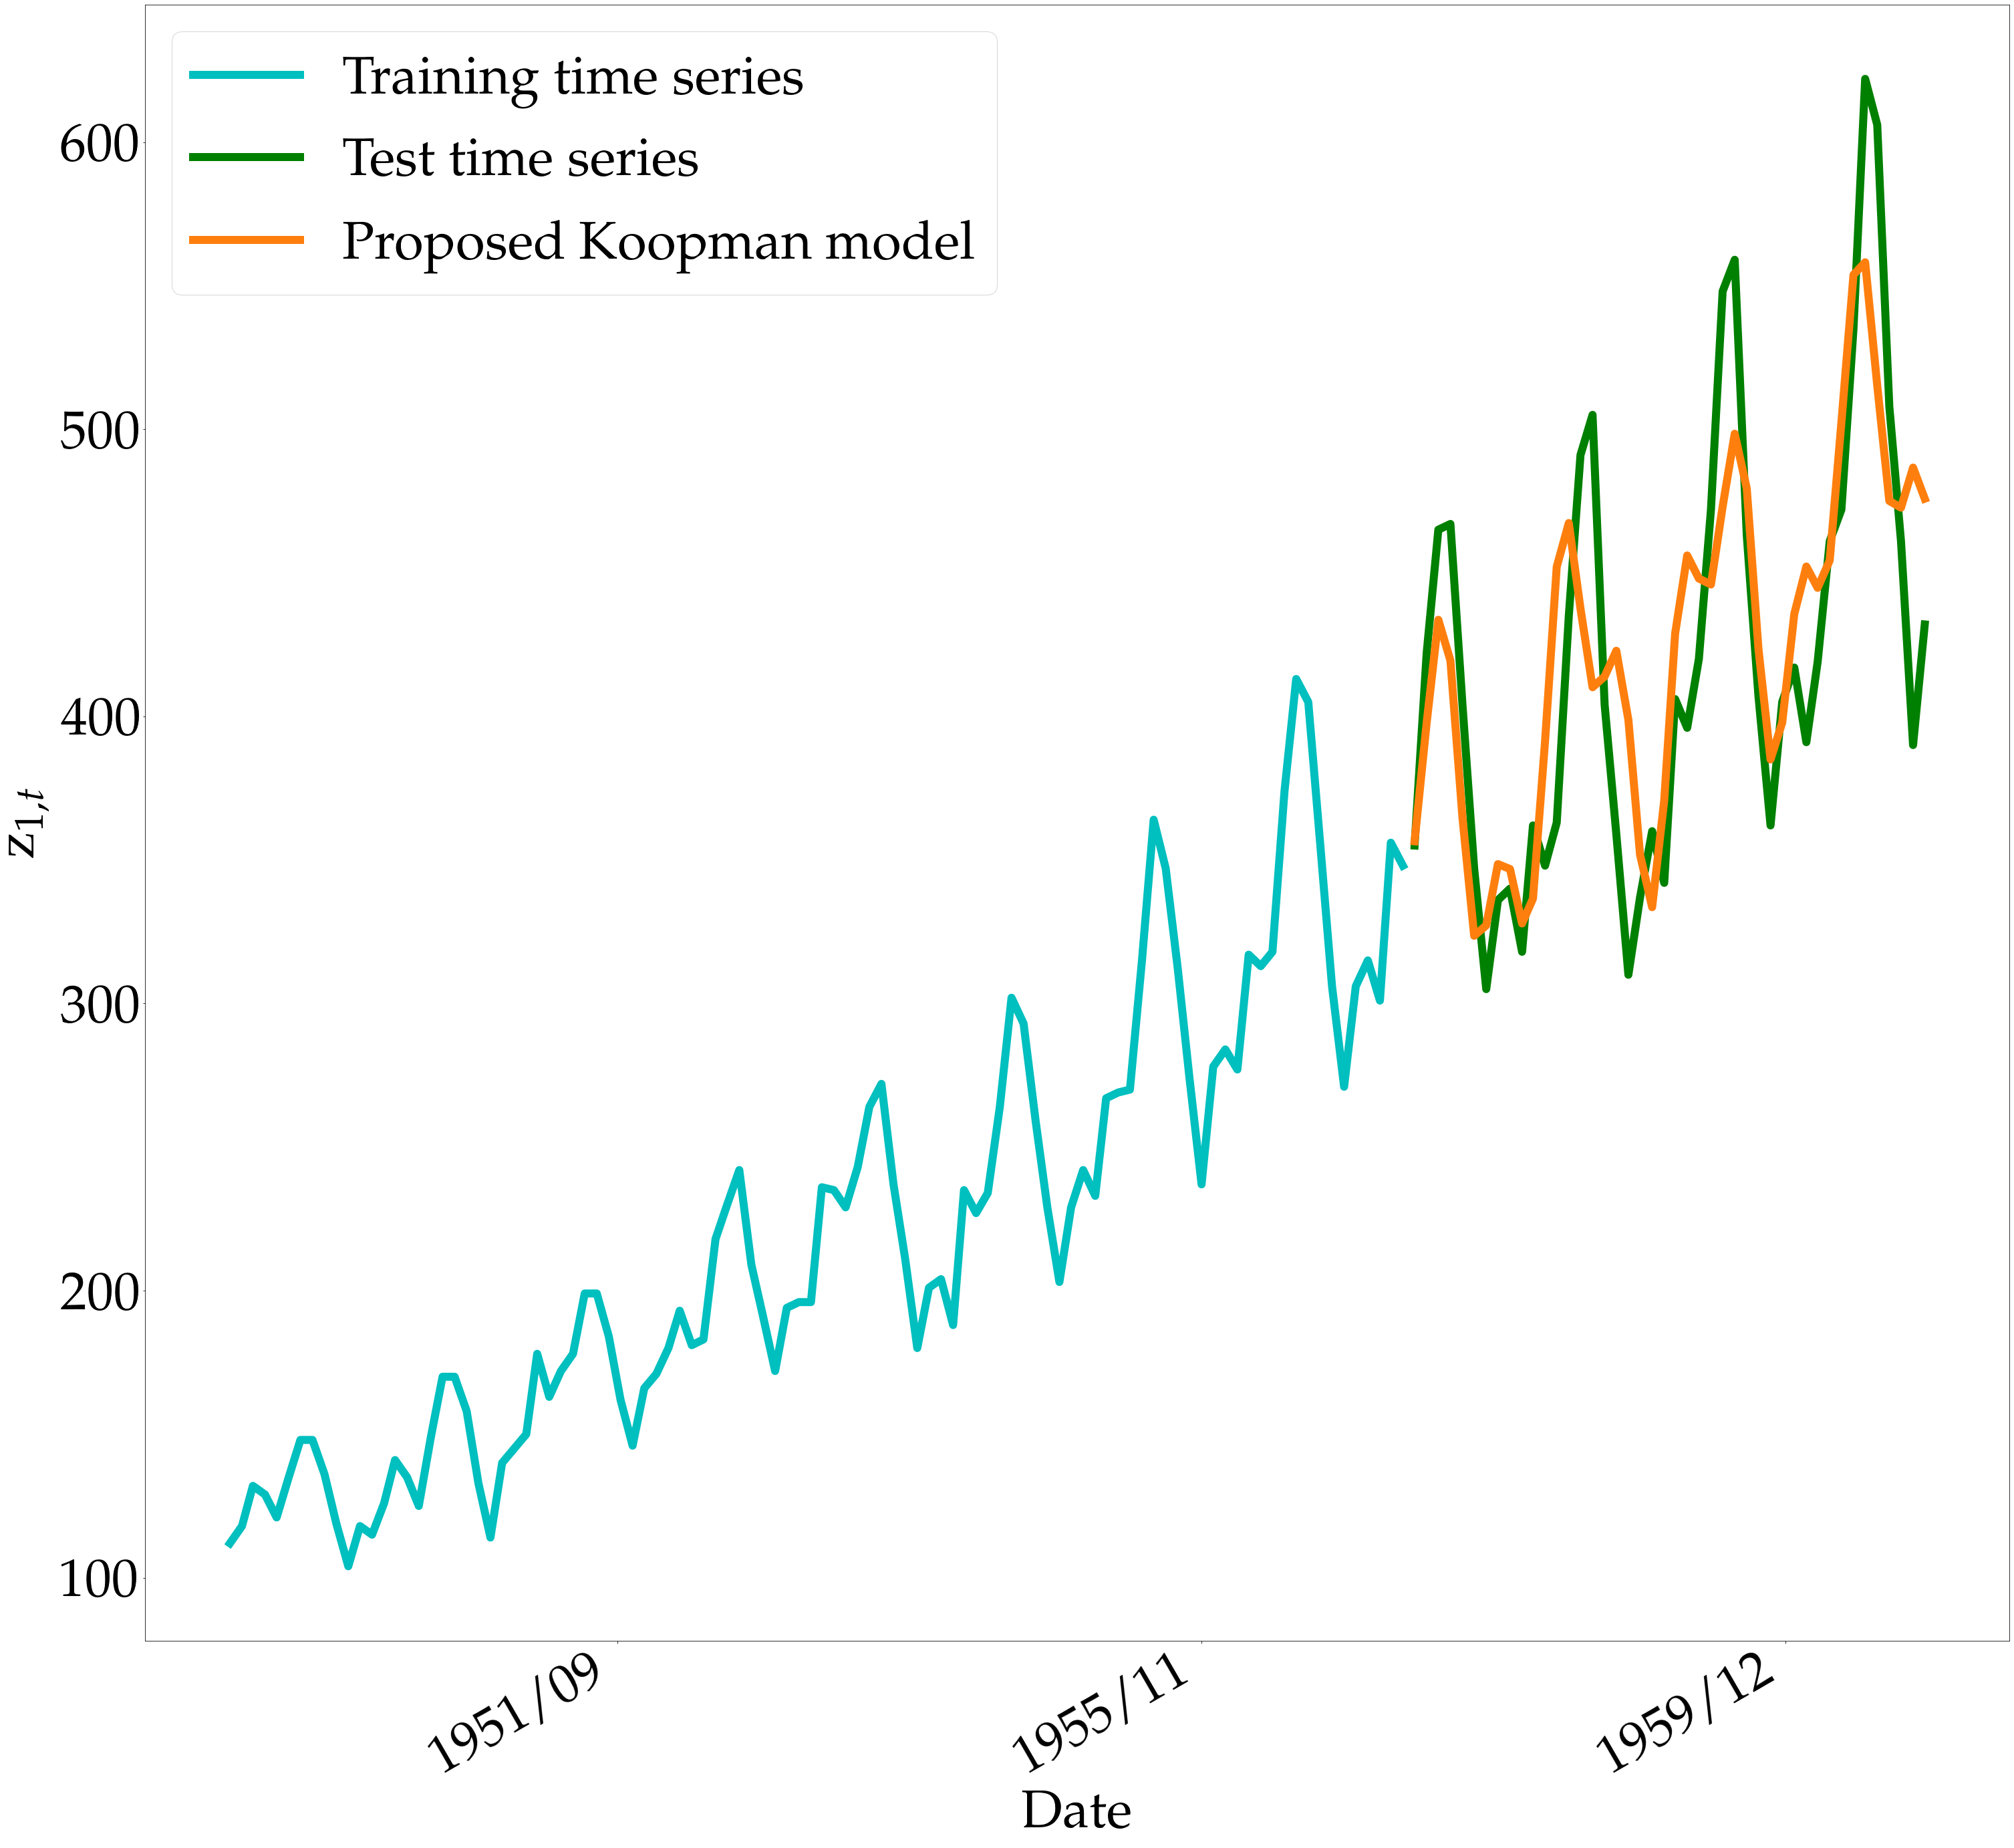

In [15]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros((res['train_data'].shape[1]+res['test_data'].shape[1],1))*np.nan
test_series      = np.zeros((res['train_data'].shape[1]+res['test_data'].shape[1],1))*np.nan
predicted_series = np.zeros((res['train_data'].shape[1]+res['test_data'].shape[1],1))*np.nan
train_series[:res['train_data'].shape[1],:]     = res['train_data'][0,:,:]
test_series[res['train_data'].shape[1]:,:]      = res['test_data'][0,:,:]
predicted_series[res['train_data'].shape[1]:,:] = res['infered_test'][0,1:res['test_data'].shape[1]+1,:1]

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1500))
plt.plot(formated_dates,train_series,lw = 12,c = 'c',label = 'Training time series')
plt.plot(formated_dates,test_series,lw = 12,c = 'g',label = 'Test time series')
plt.plot(formated_dates,predicted_series,lw = 12,c = 'tab:orange',label = 'Proposed Koopman model')
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('${\mathrm{z}}_{1,t}$')
plt.legend(markerscale=2)